This is the first project by Dean, Longhao and Senh. We start with a classical Titanic dataframe downloaded from Kaggle. https://www.kaggle.com/c/titanic

The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [158]:
#Start with importing data from local file
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style="ticks", color_codes=True)


In [146]:
titanic = pd.read_csv('train.csv')
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


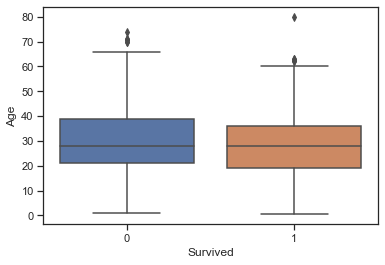

In [147]:
titanic['Age']=titanic['Age'].astype(float)
sns.boxplot(x="Survived", y="Age", data=titanic);


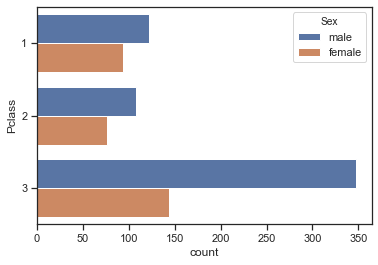

In [155]:
sns.countplot( y="Pclass", hue="Sex", data=titanic)

From this plot we can see that young passengers(children), high fare passengers are more likely to survive.

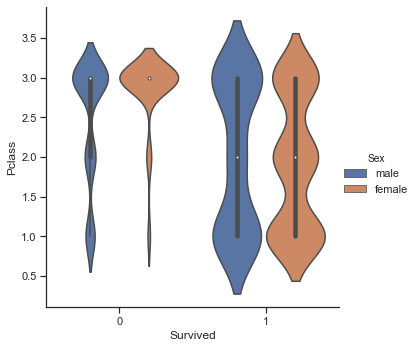

In [150]:
sns.catplot(x="Survived", y="Pclass", hue="Sex",
            kind="violin", data=titanic);

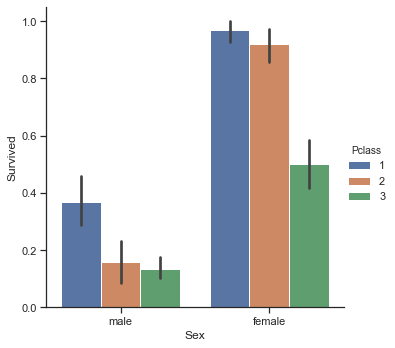

In [156]:
sns.catplot(x="Sex", y="Survived", hue="Pclass", kind="bar", data=titanic);

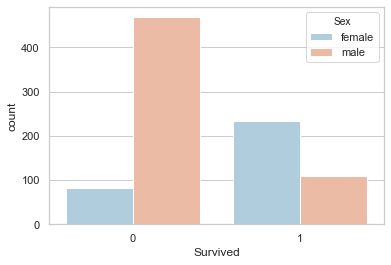

In [183]:
sns.set_style("whitegrid")
sns.countplot(x='Survived',hue="Sex",data=titanic,palette='RdBu_r')

A large group of 3rd class passengers did not survive.

Next step would be to do some feature engineering.

In [162]:
#Seperate children from adults
titanic['Age']=titanic['Age'].astype(float)
titanic.loc[titanic['Age'] <= 10, 'Children_Under_10'] = 'Children'
titanic.loc[titanic['Age'] > 10, 'Children_Under_10'] = 'Adults'
#titanic['Children_Under_10'] = titanic['Age'].apply(lambda x: if x > 10, return "Adult")
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Children_Under_10
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Adults
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adults
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Adults
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Adults
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Adults
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Adults
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Adults
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Adults


In [191]:
titanic['Sex_dummy'] = pd.get_dummies(titanic["Sex"],drop_first=True)
titanic['Children_dummy'] = pd.get_dummies(titanic["Children_Under_10"],drop_first=True)
cols = ['Pclass','Sex_dummy', 'Fare','Children_dummy']
titanic['Sex'] = titanic["Sex"].astype('category')
titanic['Children_Under_10'] = titanic["Children_Under_10"].astype('category')
titanic['Survived'] = titanic["Survived"].astype('category')
X=titanic[cols]
y=titanic['Survived']

titanic.head(2)

logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.500109
         Iterations 6
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.249     
Dependent Variable: Survived         AIC:              899.1947  
Date:               2020-07-05 16:45 BIC:              918.3641  
No. Observations:   891              Log-Likelihood:   -445.60   
Df Model:           3                LL-Null:          -593.33   
Df Residuals:       887              LLR p-value:      9.5550e-64
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Pclass            0.0132   0.0496   0.2669 0.7895 -0.0840  0.1105
Sex_dummy        -2.0120   0.1615 -12.4575 0.0000 -2.3285 -1.6954


In [166]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId          891 non-null int64
Survived             891 non-null int64
Pclass               891 non-null int64
Name                 891 non-null object
Sex                  891 non-null object
Age                  714 non-null float64
SibSp                891 non-null int64
Parch                891 non-null int64
Ticket               891 non-null object
Fare                 891 non-null float64
Cabin                204 non-null object
Embarked             889 non-null object
Children_Under_10    714 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB
